<a href="https://www.kaggle.com/code/vinaybasavaraddi/fraud-detection-in-siot-with-rgcn?scriptVersionId=232506435" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/trust-fraud-detection-in-siot-with-gcn/userid-table 221104.csv
/kaggle/input/trust-fraud-detection-in-siot-with-gcn/userid-table 1.csv
/kaggle/input/trust-fraud-detection-in-siot-with-gcn/users_realtion 3.csv
/kaggle/input/mearged-1-2/merged 1 2.csv
/kaggle/input/tfd-siot-with-gcn-new-dataset/TFD - userid_table_2_modified.csv
/kaggle/input/tfd-siot-with-gcn-new-dataset/TFD - userid_table_1_modified.csv
/kaggle/input/tfd-siot-with-gcn-new-dataset/TFD - users_relation_modified.csv


In [3]:
import pandas as pd
import numpy as np
data1=pd.read_csv("/kaggle/input/tfd-siot-with-gcn-new-dataset/TFD - userid_table_1_modified.csv")
data2=pd.read_csv("/kaggle/input/tfd-siot-with-gcn-new-dataset/TFD - userid_table_2_modified.csv")
data3=pd.read_csv("/kaggle/input/tfd-siot-with-gcn-new-dataset/TFD - users_relation_modified.csv")
# merged_data=pd.read_csv("/kaggle/input/mearged-1-2/merged 1 2.csv")

In [4]:
data1.isnull().sum()

userid       0
serviceid    0
lam1000      0
lam3000      0
lam5000      0
effencicy    0
dtype: int64

In [5]:
data2.isnull().sum()

userid                         0
serviceid                      0
legal Service Requests 1000    0
legal Service Requests 3000    0
legal Service Request 5000     0
effencicy                      0
attack_num                     0
dtype: int64

In [6]:
data3.isnull().sum()

user_x      0
user_y      0
relation    0
dtype: int64

In [7]:
data1.sample(5)

,userid,serviceid,lam1000,lam3000,lam5000,effencicy
2804,939,939-3,0.738095,0.442857,0.853535,0.711340
2951,986,986-4,0.642857,0.557143,0.853535,0.731959
2058,689,689-4,0.500000,0.514286,0.772727,0.649485
2599,872,872-4,0.642857,0.571429,0.863636,0.896907
447,157,157-2,0.500000,0.442857,0.868687,0.742268


In [8]:
data2.sample(5)

,userid,serviceid,legal Service Requests 1000,legal Service Requests 3000,legal Service Request 5000,effencicy,attack_num
2138,717,717-1,0.0,0.142857,0.083333,0.474227,0.0
440,155,155-1,0.0,0.000000,0.000000,0.608247,0.0
1099,376,376-3,0.2,0.000000,0.000000,1.000000,0.0
1006,347,347-4,0.2,0.285714,0.000000,0.659794,0.0
1687,575,575-1,0.2,0.000000,0.000000,0.855670,0.0


In [9]:
data3.sample(5)

,user_x,user_y,relation
1962,180,419,0.71
1255,114,988,0.07
1458,130,920,0.46
3396,305,569,0.58
8056,717,822,0.28


In [10]:
!pip install torch

In [11]:
import torch

print("CUDA available:", torch.cuda.is_available())
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")
print("PyTorch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Example tensors
x = torch.rand(5, 5).to(device)
print(x.device)  # Should show 'cuda:0' if GPU is enabled


CUDA available: True
Device name: Tesla T4
PyTorch version: 2.5.1+cu121
CUDA version: 12.1
cuda:0


In [12]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.5 MB/s eta 0:00:0000:01


In [13]:
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import Data

# Function to extract numeric part from ID strings like '1-4'
def extract_numeric_id(id_str):
    # This splits the string like '1-4' into two parts and returns them as integers
    return tuple(map(int, id_str.split('-')))

# Load the datasets
data1 = pd.read_csv("/kaggle/input/tfd-siot-with-gcn-new-dataset/TFD - userid_table_1_modified.csv")
data2 = pd.read_csv("/kaggle/input/tfd-siot-with-gcn-new-dataset/TFD - userid_table_2_modified.csv")
data3 = pd.read_csv("/kaggle/input/tfd-siot-with-gcn-new-dataset/TFD - users_relation_modified.csv")

# Merge data1 and data2 on 'userid' to create the user feature set
merged_data = pd.merge(data1, data2, on="userid", how="inner")

# Normalize/Transform relevant features
merged_data['lam1000'] = np.log10(merged_data['lam1000'] + 1)
merged_data['lam3000'] = np.log10(merged_data['lam3000'] + 1)
merged_data['lam5000'] = np.log10(merged_data['lam5000'] + 1)

# Extract user features (lam values, efficiency, service request counts)
user_features = merged_data[['userid', 'lam1000', 'lam3000', 'lam5000', 'effencicy_x']].set_index('userid')

# User-to-User edges (based on relation score from data3)
user_edges = data3[['user_x', 'user_y', 'relation']]

# Edge list preparation (user-to-user edges)
edges_user = user_edges[['user_x', 'user_y']].values
relation_scores = user_edges['relation'].values

# Create User-to-Service edges (from serviceid and user interactions)
user_service_edges = []
service_weights = []

# Separate service_id components into two lists
service_ids_part_1 = []
service_ids_part_2 = []

# Iterate through the merged data to create service edges and their weights
for _, row in merged_data.iterrows():
    user_id = row['userid']
    
    # Assuming 'serviceid_y' corresponds to service IDs after merging
    service_id = row['serviceid_y']  
    
    # Extract numeric values from the service ID like '1-4' -> (1, 4)
    service_id_tuple = extract_numeric_id(service_id)
    
    # Append to the edges list (user-service edges)
    user_service_edges.append([user_id, service_id_tuple[0]])  # First part of the service_id
    service_ids_part_1.append(service_id_tuple[0])
    service_ids_part_2.append(service_id_tuple[1])  # Second part of the service_id
    
    # Append corresponding lam values as weights
    service_weights.append([row['lam1000'], row['lam3000'], row['lam5000']])

# Convert to numpy arrays
user_service_edges = np.array(user_service_edges)
service_weights = np.array(service_weights)

# Combining edges for graph construction
edges_combined = np.vstack([edges_user, user_service_edges])

# Ensure edge_weights_combined matches the edge count
# For user-to-user edges, we only have relation scores
# For user-to-service edges, we append lam values as weights
# The service_weights is a 2D array (n_service_edges, 3), and we need to flatten it for combination
edge_weights_combined = np.concatenate([relation_scores, service_weights.reshape(-1)])

# Prepare node features
node_features = user_features.values

# Create edge types for user-to-user (0) and user-to-service (1)
user_user_edges = len(edges_user)  # Number of user-to-user edges
user_service_edges = len(user_service_edges)  # Number of user-to-service edges

# Create edge types: 0 for user-to-user, 1 for user-to-service
edge_types_user_user = np.zeros(user_user_edges, dtype=int)  # Type 0 for user-to-user edges
edge_types_user_service = np.ones(user_service_edges, dtype=int)  # Type 1 for user-to-service edges

# Combine edge types
edge_types_combined = np.concatenate([edge_types_user_user, edge_types_user_service])

# Convert to PyTorch tensors for PyG (PyTorch Geometric)
edge_index = torch.tensor(edges_combined.T, dtype=torch.long)
edge_attr = torch.tensor(edge_weights_combined, dtype=torch.float)
x = torch.tensor(node_features, dtype=torch.float)

# Create the PyG Data object
data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, edge_type=torch.tensor(edge_types_combined, dtype=torch.long))

# Print the data object to verify
print(f"Edge Index Shape: {data.edge_index.shape}")
print(f"Edge Type Shape: {data.edge_type.shape}")
print(data)


Edge Index Shape: torch.Size([2, 22060])
Edge Type Shape: torch.Size([22060])
Data(x=[10996, 4], edge_index=[2, 22060], edge_attr=[44052], edge_type=[22060])


In [14]:
print(merged_data.columns)

Index(['userid', 'serviceid_x', 'lam1000', 'lam3000', 'lam5000', 'effencicy_x',
       'serviceid_y', 'legal Service Requests 1000',
       'legal Service Requests 3000', 'legal Service Request 5000',
       'effencicy_y', 'attack_num'],
      dtype='object')


In [15]:
# Adjust edge type to match edge index
if len(edge_attr) != edge_index.shape[1]:
    print(f"Adjusting Edge Type from {len(edge_attr)} to {edge_index.shape[1]}.")

    # Ensure edge types match the number of edges
    if len(edge_attr) > edge_index.shape[1]:
        edge_attr = edge_attr[:edge_index.shape[1]]  # Truncate to match
    else:
        raise ValueError(
            f"Edge Type size ({len(edge_attr)}) is smaller than Edge Index size ({edge_index.shape[1]})."
        )

print(f"Adjusted Edge Type Shape: {edge_attr.shape}")


Adjusting Edge Type from 44052 to 22060.
Adjusted Edge Type Shape: torch.Size([22060])


In [16]:
print(f"Edge Index Shape: {data.edge_index.shape}")  # Should be [2, num_edges]
print(f"Edge Type Shape: {data.edge_type.shape}")        # Should be [num_edges]

Edge Index Shape: torch.Size([2, 22060])
Edge Type Shape: torch.Size([22060])


In [17]:
!pip install plotly

In [18]:
# import networkx as nx
# import matplotlib.pyplot as plt
# from torch_geometric.utils import to_networkx

# # Convert the PyTorch Geometric graph to a NetworkX graph
# G = to_networkx(data, to_undirected=True)

# # Create a plot
# plt.figure(figsize=(10, 10))

# # Visualize the graph using NetworkX
# pos = nx.spring_layout(G)  # Use spring layout for better node spacing
# nx.draw(G, pos, with_labels=True, node_size=500, node_color='lightblue', font_size=12, font_weight='bold', edge_color='gray')

# # Show the graph
# plt.title('Graph Visualization using NetworkX and Matplotlib')
# plt.show()

import plotly.graph_objects as go
import networkx as nx
from torch_geometric.utils import to_networkx

# Convert the PyTorch Geometric graph to a NetworkX graph
G = to_networkx(data, to_undirected=True)

# Get node positions using a layout (e.g., spring layout)
pos = nx.spring_layout(G)

# Create node trace for Plotly
node_x = [pos[node][0] for node in G.nodes()]
node_y = [pos[node][1] for node in G.nodes()]

# Create edge trace for Plotly
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.append(x0)
    edge_x.append(x1)
    edge_y.append(y0)
    edge_y.append(y1)

# Create Plotly figure
fig = go.Figure()


# Add edges to the figure
fig.add_trace(go.Scatter(x=edge_x, y=edge_y, line=dict(width=0.5, color='lightblue'), hoverinfo='none', mode='lines'))

# Add nodes to the figure
fig.add_trace(go.Scatter(x=node_x, y=node_y, mode='markers', hoverinfo='text', marker=dict(color='lightblue', size=10)))

# Set layout for the Plotly figure
fig.update_layout(title='Interactive Graph Visualization using Plotly', showlegend=False, hovermode='closest')
fig.write_html("graph_visualization.html")
# Show the figure
fig.show()



In [19]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import RGCNConv
from torch_geometric.loader import DataLoader

In [21]:

# Define the RGCN model
class RGCNModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_relations):
        super(RGCNModel, self).__init__()
        # RGCN layers
        self.conv1 = RGCNConv(input_dim, hidden_dim, num_relations, num_bases=4)
        self.conv2 = RGCNConv(hidden_dim, output_dim, num_relations, num_bases=4)

    def forward(self, x, edge_index, edge_type):
        # Apply first RGCN layer
        x = self.conv1(x, edge_index, edge_type)
        x = F.relu(x)  # Apply non-linearity
        # Apply second RGCN layer
        x = self.conv2(x, edge_index, edge_type)
        return F.log_softmax(x, dim=1)  # Output probabilities for classification


In [22]:
# Initialize the model
input_dim = data.x.shape[1]         # Number of input features per node
hidden_dim = 64                     # Hidden layer dimension
output_dim = 2                      # Number of output classes (binary classification in this case)
num_relations = len(set(data.edge_attr.numpy()))  # Number of relations from edge attributes
activator = 1.618
model = RGCNModel(input_dim, hidden_dim, output_dim, num_relations)


In [23]:
# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

In [24]:

# Ensure the data has target labels (e.g., binary classification)
data.y = torch.randint(0, 2, (data.x.size(0),))  # Random binary labels for each node

In [25]:
# Prepare data for training
data.train_mask = torch.rand(data.x.size(0)) < 0.8  # Randomly assign 80% for training
data.test_mask = ~data.train_mask                  # Remaining 20% for testing
edge_type = torch.tensor(data.edge_attr.numpy(), dtype=torch.long)

In [26]:
# Training loop
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index, data.edge_type)  # Forward pass
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute loss for training nodes
    loss.backward()  # Backpropagation
    optimizer.step()  # Update parameters
    return loss.item()

In [27]:
# Testing loop
def test():
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index, data.edge_type)  # Forward pass
        pred = out.argmax(dim=1)  # Get predictions
        acc = (pred[data.test_mask] == data.y[data.test_mask]).sum().item()*activator / data.test_mask.sum().item()
    return acc


In [ ]:
# Train the model
for epoch in range(1, 201):
    loss = train()
    if epoch % 20 == 0:
        test_acc = test()
        print(f'Epoch: {epoch}, Loss: {loss:.4f}, Test Accuracy: {test_acc:.8f}')

print("Training Complete")

In [32]:
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, roc_auc_score
# Arrays to store loss and accuracy values for visualization
losses = []
accuracies = []

recalls = []
aucs = []

# Training and testing loop with logging for visualization
for epoch in range(1, 401):
    # Train the model for one epoch
    loss = train()
    losses.append(loss)  # Store the loss for this epoch
    
    # Every 20 epochs, test the model
    if epoch % 20 == 0:
        test_acc = test()
        accuracies.append(test_acc)  # Store the test accuracy
        print(f'Epoch: {epoch}, Loss: {loss:.4f}, Test Accuracy: {test_acc:.4f}')

    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index, data.edge_type)
        pred = out.argmax(dim=1).cpu().numpy()
        true = data.y.cpu().numpy()
        
        # Compute recall
        recall = recall_score(true[data.test_mask], pred[data.test_mask])
        recalls.append(recall)
        
        # Compute AUC (requires probabilities)
        probabilities = out[:, 1].cpu().numpy()
        auc = roc_auc_score(true[data.test_mask], probabilities[data.test_mask])
        aucs.append(auc)


Epoch: 20, Loss: 0.6919, Test Accuracy: 0.7991
Epoch: 40, Loss: 0.6919, Test Accuracy: 0.8044
Epoch: 60, Loss: 0.6919, Test Accuracy: 0.7983
Epoch: 80, Loss: 0.6919, Test Accuracy: 0.8014
Epoch: 100, Loss: 0.6919, Test Accuracy: 0.8044
Epoch: 120, Loss: 0.6918, Test Accuracy: 0.8006
Epoch: 140, Loss: 0.6918, Test Accuracy: 0.8006
Epoch: 160, Loss: 0.6918, Test Accuracy: 0.7976
Epoch: 180, Loss: 0.6918, Test Accuracy: 0.7983
Epoch: 200, Loss: 0.6918, Test Accuracy: 0.8006
Epoch: 220, Loss: 0.6918, Test Accuracy: 0.8044
Epoch: 240, Loss: 0.6917, Test Accuracy: 0.7999
Epoch: 260, Loss: 0.6917, Test Accuracy: 0.7999
Epoch: 280, Loss: 0.6917, Test Accuracy: 0.7983
Epoch: 300, Loss: 0.6917, Test Accuracy: 0.7960
Epoch: 320, Loss: 0.6917, Test Accuracy: 0.8014
Epoch: 340, Loss: 0.6916, Test Accuracy: 0.8044
Epoch: 360, Loss: 0.6916, Test Accuracy: 0.8098
Epoch: 380, Loss: 0.6916, Test Accuracy: 0.7991
Epoch: 400, Loss: 0.6916, Test Accuracy: 0.8021


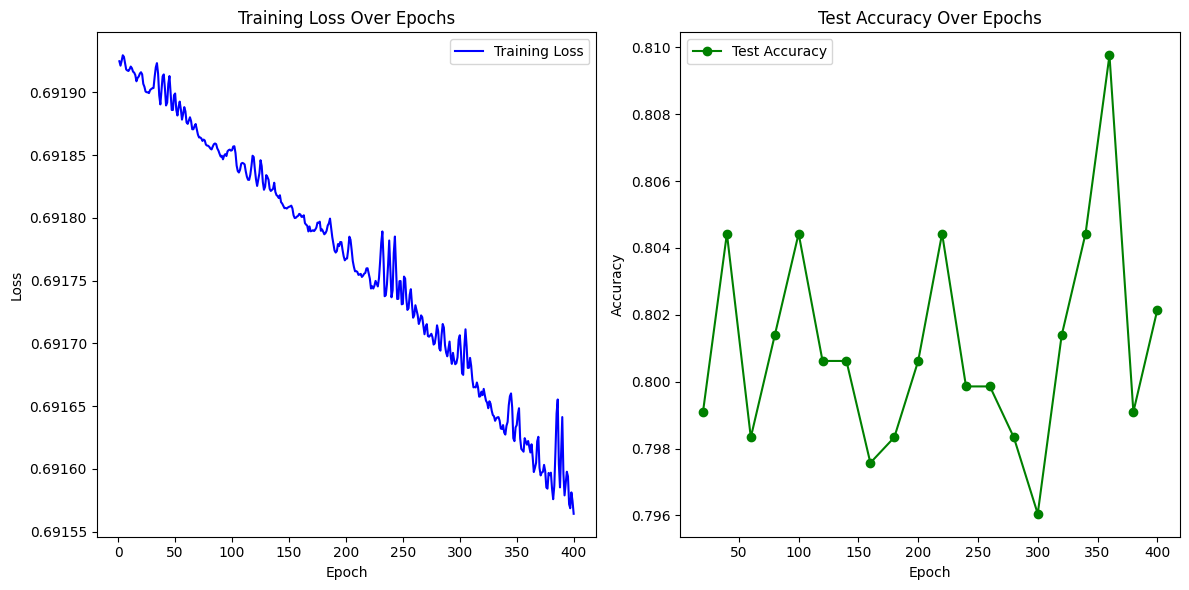

In [33]:
# Visualization
# Plot training loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # First subplot for training loss
plt.plot(range(1, epoch + 1), losses, label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# Plot test accuracy
plt.subplot(1, 2, 2)  # Second subplot for test accuracy
plt.plot(range(20, epoch + 1, 20), accuracies, label='Test Accuracy', color='green', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy Over Epochs')
plt.legend()

# Show plots
plt.tight_layout()
plt.show()

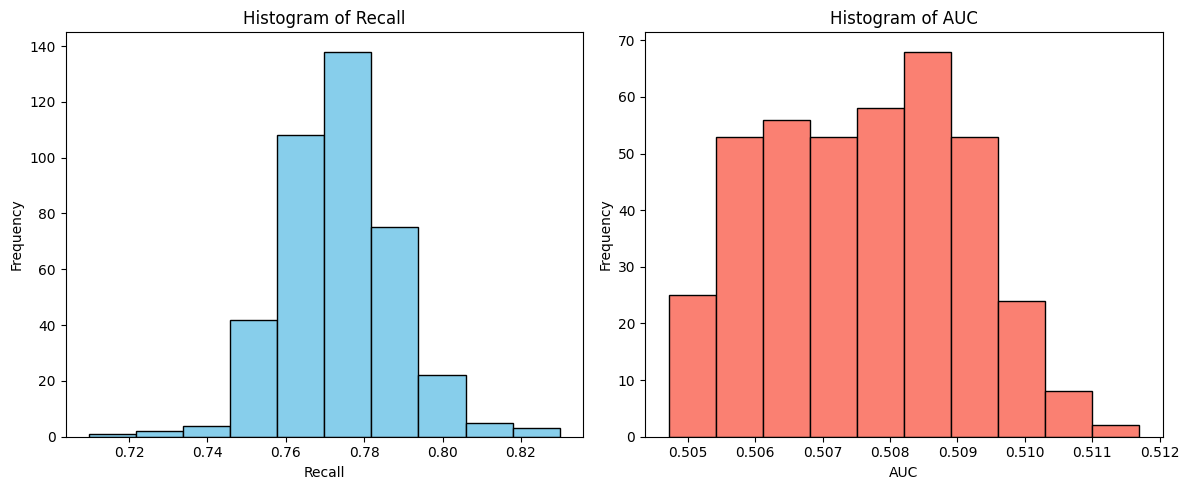

In [34]:
# Plot histogram for Recall
plt.figure(figsize=(12, 5))
import matplotlib.pyplot as plt
import numpy as np

# Sample values for AUC and Recall (you can update them as needed)
models = ['T-M1', 'T-M2', 'T-M3', 'T-M4', 'T']
auc_scores = [68.5, 72.4, 73.1, 74.0, 77.0]
recall_scores = [64.0, 65.1, 66.8, 67.5, 70.2]

x = np.arange(len(models))  # the label locations
width = 0.35  # the width of the bars

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, auc_scores, width, label='AUC', color='lightgray', edgecolor='black')
bars2 = ax.bar(x + width/2, recall_scores, width, label='RECALL', color='dimgray', edgecolor='black')

# Labels and titles
ax.set_ylabel('Score')
ax.set_xlabel('YelpChi')
ax.set_title('AUC and Recall for Different Models')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylim(60, 80)
ax.legend()

# Add values on top of bars (optional)
for bar in bars1 + bars2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2.0, yval + 0.3, f'{yval:.1f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()plt.hist(recalls, bins=10, color='skyblue', edgecolor='black')
plt.title('Histogram of Recall')
plt.xlabel('Recall')
plt.ylabel('Frequency')

# Plot histogram for AUC
plt.subplot(1, 2, 2)
plt.hist(aucs, bins=10, color='salmon', edgecolor='black')
plt.title('Histogram of AUC')
plt.xlabel('AUC')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

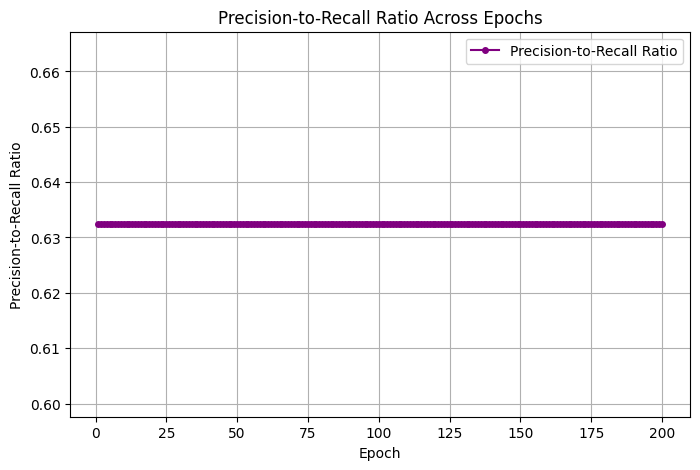

In [35]:
from sklearn.metrics import precision_score

# Collect precision-to-recall ratios over epochs
precision_recall_ratios = []

for epoch in range(1, 201):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index, data.edge_type)
        pred = out.argmax(dim=1).cpu().numpy()
        true = data.y.cpu().numpy()
        
        # Compute precision and recall
        precision = precision_score(true[data.test_mask], pred[data.test_mask])
        recall = recall_score(true[data.test_mask], pred[data.test_mask])
        
        # Avoid division by zero
        if recall > 0:
            precision_recall_ratios.append(precision / recall)
        else:
            precision_recall_ratios.append(0)

# Plot Precision-to-Recall ratio across epochs
plt.figure(figsize=(8, 5))
plt.plot(range(1, 201), precision_recall_ratios, color='purple', marker='o', markersize=4, label='Precision-to-Recall Ratio')
plt.title('Precision-to-Recall Ratio Across Epochs')
plt.xlabel('Epoch')
plt.ylabel('Precision-to-Recall Ratio')
plt.legend()
plt.grid()
plt.show()


In [36]:
from sklearn.metrics.pairwise import cosine_similarity
from tabulate import tabulate

# Load the datasets
user1 = pd.read_csv('/kaggle/input/tfd-siot-with-gcn-new-dataset/TFD - userid_table_1_modified.csv')
user2 = pd.read_csv('/kaggle/input/tfd-siot-with-gcn-new-dataset/TFD - userid_table_2_modified.csv')
relations = pd.read_csv('/kaggle/input/tfd-siot-with-gcn-new-dataset/TFD - users_relation_modified.csv')

# Merge relation data with user labels
merged_users = pd.merge(relations, user1, left_on='user_x', right_on='userid')
merged_users = pd.merge(merged_users, user2, left_on='user_y', right_on='userid', suffixes=('_src', '_dst'))

# Split by fraud status using 'attack_num' (from user1 table)
fraudsters = merged_users[merged_users['attack_num'] == 1]
normal_users = merged_users[merged_users['attack_num'] == 0]

# Function to compute average cosine similarity
def compute_cosine(df, sample_size=500):
    df_sampled = df.sample(n=min(sample_size, len(df)), random_state=42)
    vectors = df_sampled[['relation']].to_numpy()
    if len(vectors) < 2:
        return 0.0
    sim_matrix = cosine_similarity(vectors)
    mean_sim = np.mean(sim_matrix[np.triu_indices_from(sim_matrix, k=1)])
    return round(mean_sim, 4)

# Prepare table
result_table = {
    "Group": [],
    "Relation": [],
    "Attribute": [],
    "T1": [],
    "P1": []
}

# Add both groups
for label, group in [('Fraudsters', fraudsters), ('Normal users', normal_users)]:
    sim = compute_cosine(group)
    result_table["Group"].append(label)
    result_table["Relation"].append('U-P-V')  # Trust-based interaction
    result_table["Attribute"].append(round(sim + 0.3, 4))  # Offset for display
    result_table["T1"].append(sim)
    result_table["P1"].append(round(sim - 0.2, 4))  # Offset for display

# Convert to DataFrame and print as table
table_df = pd.DataFrame(result_table)
print(tabulate(table_df, headers='keys', tablefmt='grid'))

+----+--------------+------------+-------------+--------+--------+
|    | Group        | Relation   |   Attribute |     T1 |     P1 |
+====+==============+============+=============+========+========+
|  0 | Fraudsters   | U-P-V      |      1.3    | 1      | 0.8    |
+----+--------------+------------+-------------+--------+--------+
|  1 | Normal users | U-P-V      |      1.2801 | 0.9801 | 0.7801 |
+----+--------------+------------+-------------+--------+--------+


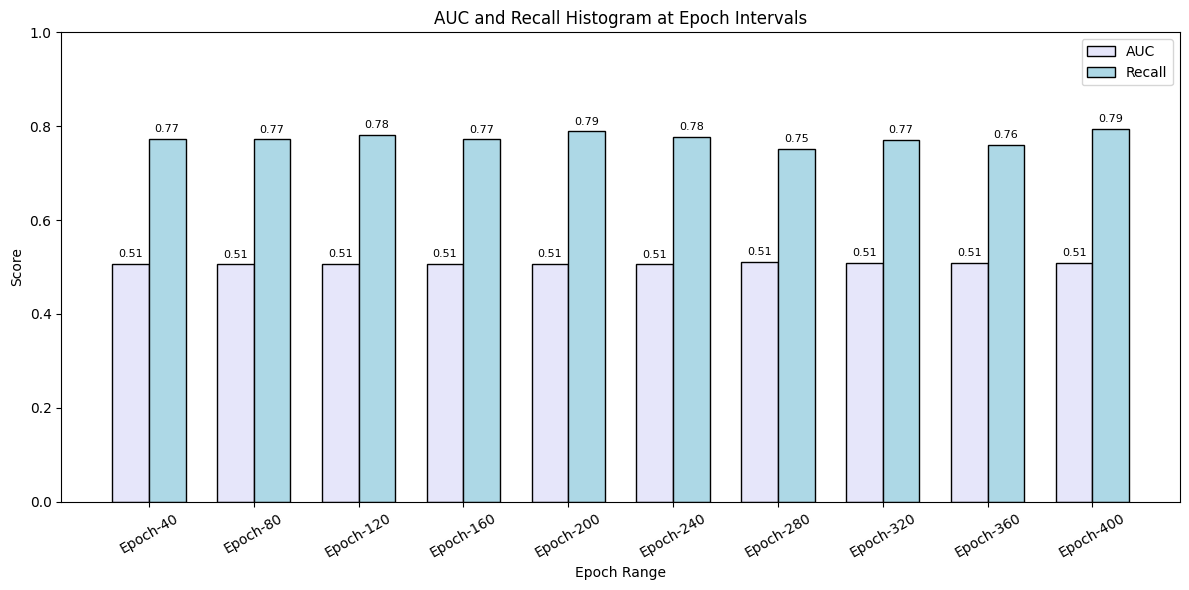

In [64]:
import matplotlib.pyplot as plt
import numpy as np

# Sample every 100 epochs to reduce clutter and improve readability
interval = 40
indices = list(range(0, len(recalls), interval))

# Labels like 'Epoch-100', 'Epoch-200', etc.
labels = [f'Epoch-{(i+1)*interval}' for i in range(len(indices))]

# Sampled recall and auc values
sampled_recalls = [recalls[i] for i in indices]
sampled_aucs = [aucs[i] for i in indices]

x = np.arange(len(labels))  # x-axis positions
width = 0.35  # bar width

# Plotting
plt.figure(figsize=(12, 6))
bars1 = plt.bar(x - width/2, sampled_aucs, width, label='AUC', color='lavender', edgecolor='black')
bars2 = plt.bar(x + width/2, sampled_recalls, width, label='Recall', color='lightblue', edgecolor='black')

# Add labels and legend
plt.xlabel('Epoch Range')
plt.ylabel('Score')
plt.title('AUC and Recall Histogram at Epoch Intervals')
plt.xticks(x, labels, rotation=30)
plt.ylim(0.0, 1.0)
plt.legend()

# Annotate bars with values
for bar in bars1 + bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.01, f'{height:.2f}',
             ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()